# NOAA 自然重建数据的处理

这个笔记本展示如何处理 NOAA 自然重建数据，如何进行贝叶斯组合，如何进行空间代表性分析，并制作论文的第一小节数据插图。

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import os
from hydra import compose, initialize
from shifting_baseline.utils.log import get_logger, adjust_log_level

with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config.yaml")
os.chdir(cfg.ds.root)

# 在 notebook 中动态调整日志等级
log = get_logger()
adjust_log_level(console_level="INFO", file_level="DEBUG")

In [3]:
# 需要写到论文里的预期结果
expected_results = {
    "n_datasets": None,
    "corr_with_validation": None,
    "n_pass_years": None,
    "sig_sites_percentage": None,
    "sig_sites_ratio": None,
    "n_sites_sig005": None,
    "n_sites_sig01": None,
}

## 筛选与合并数据

### 读取数据

我们一共整理了 13 套在 NOAA 上可以自由下载的[使用树轮重建的古气候数据](https://docs.google.com/spreadsheets/d/1HAICoWO_Uh40iDllIUKE3nYOCVLGNgfWML-6ecTKegU/edit?usp=sharing)。

In [4]:
from shifting_baseline.data import load_nat_data
from shifting_baseline.constants import START

datasets, uncertainties = load_nat_data(
    folder=cfg.ds.noaa,
    includes=cfg.ds.includes,
    start_year=START,
    standardize=True,
)
datasets.tail()

INFO | 从 /Users/songshgeo/Documents/Datasets/东亚古气候重建数据 加载自然数据: chen2020f, li2015b, li2019a, liu2020, shi2017, shi2018, tan2011, xu2023c, yang2016, yi2010, yi2012


Directory /Users/songshgeo/Documents/Datasets/东亚古气候重建数据 checked.
Found 19 files in /Users/songshgeo/Documents/Datasets/东亚古气候重建数据.
Found 9 files matching the pattern.


,yi2010,yang2016,tan2011,xu2023c,liu2020,yi2012,li2015b,chen2020f,li2019a
year,,,,,,,,,
2009,NaN,-0.568723,NaN,-1.466621,-0.314233,NaN,NaN,-0.346202,2.343614
2010,NaN,0.307108,NaN,1.170888,-0.302521,NaN,NaN,-0.580140,2.828464
2011,NaN,NaN,NaN,1.248765,-0.760710,NaN,NaN,-0.752154,NaN
2012,NaN,NaN,NaN,-1.204711,0.169405,NaN,NaN,-2.389725,NaN
2013,NaN,NaN,NaN,0.140132,0.748762,NaN,NaN,NaN,NaN


其中 ，不是所有的数据都会被使用，下面是使用的数据及其时空范围：

In [5]:
import seaborn as sns
from matplotlib import pyplot as plt

# 设置绘图风格
sns.set_theme(style="white")

# 检查数据
for name, ds in datasets.items():
    if name not in cfg.ds.includes:
        print(f"{name} 在使用列表中，但没有读取成功，请检查")
        continue
    index = ds.dropna().index
    print(f"{name} 的时间范围是：{index.min()} - {index.max()}")

# 存储数据集量
expected_results["n_datasets"] = len(datasets.columns)

yi2010 的时间范围是：1600 - 2000
yang2016 的时间范围是：1470 - 2010
tan2011 的时间范围是：1005 - 1975
xu2023c 的时间范围是：1588 - 2013
liu2020 的时间范围是：1493 - 2013
yi2012 的时间范围是：1470 - 2002
li2015b 的时间范围是：1872 - 2003
chen2020f 的时间范围是：1570 - 2012
li2019a 的时间范围是：1000 - 2010


### 合并数据

现在使用贝叶斯组合方法合并数据：

In [6]:
from shifting_baseline.mc import combine_reconstructions

combined, trace = combine_reconstructions(
    datasets,
    uncertainties,
    standardize=True,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_drought, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 19 seconds.


合成的数据进行导出，在其它笔记本中进行进一步分析

In [7]:
# 导出合成数据
combined.to_csv(cfg.ds.out.tree_ring)
uncertainties.to_csv(cfg.ds.out.tree_ring_uncertainty)
combined.head()
print("合成数据导出成功, 路径为:", cfg.ds.out.tree_ring)

,mean,sd,hdi_3%,hdi_97%
year,,,,
1000,0.298,0.526,-0.706,1.278
1001,-0.019,0.536,-0.994,1.005
1002,0.779,0.615,-0.387,1.930
1003,0.421,0.685,-0.867,1.688
1004,-0.218,0.651,-1.394,1.044


合成数据导出成功, 路径为: /Users/songshgeo/Documents/VSCode/shifting_baseline/data/combined_mean.csv


### 重新加载合成后的数据

INFO | 加载自然数据 [1000-1900]...
INFO | 从文件加载处理后的自然数据 ...
INFO | 加载历史数据 ...
INFO | 处理为对称等级 ...
INFO | 处理为标准化等级 ...
INFO | 通过随机采样处理为标准化等级，生成 100 个样本 ...


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/data.py:220: RuntimeWarning: Mean of empty slice
  np.nanmean(data, axis=0),
/Users/songshgeo/Documents/VSCode/shifting_baseline/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,name_ch,name_en,region,lon,lat,NAME,省,市,geometry
15,兰州,Lanzhou,华北地区,103.726610,35.181546,临洮县,甘肃省,定西市,POINT (103.72661 35.18155)
16,天水,Tianshui,华北地区,105.600436,34.110788,秦州区,甘肃省,天水市,POINT (105.60044 34.11079)
18,银川,Yinchuan,华北地区,106.135814,37.412291,红寺堡区,宁夏回族自治区,吴忠市,POINT (106.13581 37.41229)
21,榆林,Yulin,华北地区,109.734749,38.066642,横山区,陕西省,榆林市,POINT (109.73475 38.06664)
22,延安,Yan'an,华北地区,109.556290,36.371276,宝塔区,陕西省,延安市,POINT (109.55629 36.37128)


(1000.0, 2000.0)

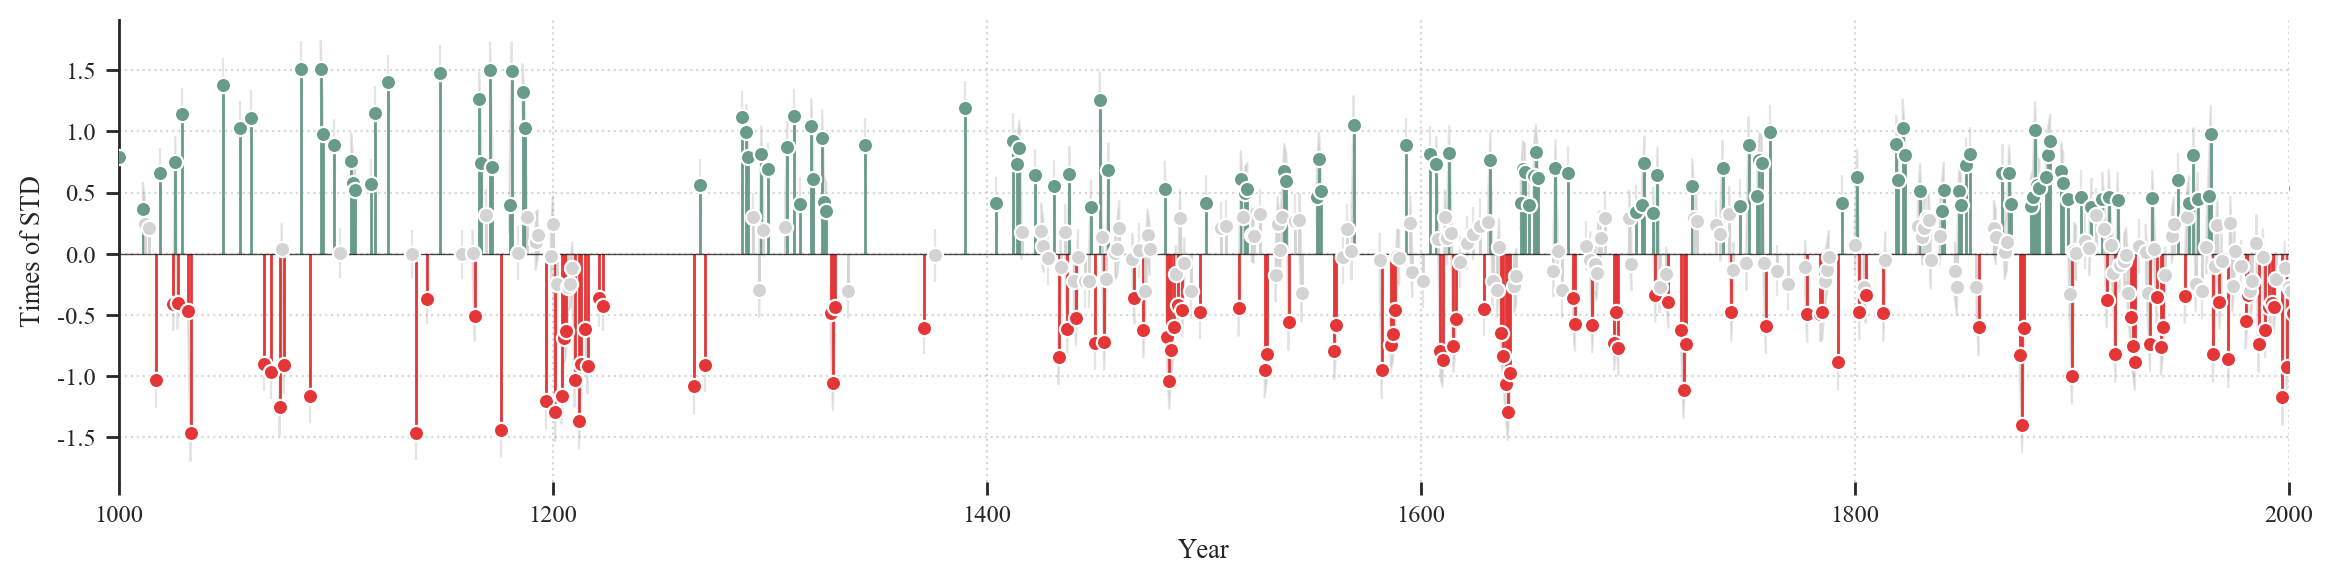

In [8]:
from shifting_baseline.data import HistoricalRecords
from shifting_baseline.utils.plot import plot_std_times
from shifting_baseline.constants import START, FINAL
from shifting_baseline.data import load_data

# 读取合成数据
combined, uncertainties, hist = load_data(cfg)

# 绘制历史数据的时间序列
region_gdf = hist.shp.copy()
region_gdf.head()

pred = hist.aggregate(to_int=False)
std = hist._std.mean(axis=1).ffill()
ax = plot_std_times(data=pred)
ax.fill_between(std.index, pred + std, pred - std, color="gray", alpha=0.2)
ax.set_xlim(START, FINAL)

## 空间代表性

计算降水量的 z-score, 得到的数据应该包括 1900-2017 年的降水：

[原始数据](https://essd.copernicus.org/articles/11/1931/2019/)来源为 ESSD 的一篇文章，这里只用了夏季（July, August, Sepetember, JAS）三个月的数据，进行聚合之后再升尺度。

注意这里，先计算每个格点 z-score 再平均，和先计算平均降水，再转化成 z-score 效果是不一样的。

我们的先计算了指数，所以再平均的是分数。

In [9]:
from shifting_baseline.data import load_validation_data

RAW_RASTER = cfg.ds.instrumental.output
Z_SCORE_RASTER = cfg.ds.out.precip_z

# 读取原始数据并重投影
summer_precip_z, regional_prec_z = load_validation_data(
    data_path=RAW_RASTER,
    resolution=cfg.resolution,
    recalculate_zscore=True,
    nc_save_to=Z_SCORE_RASTER,
    regional_csv=cfg.ds.out.regional_csv,
    sel_dict=hist.get_bounds("x", "y"),
)

INFO | 从 /Users/songshgeo/Documents/VSCode/shifting_baseline/data/JAS_precipitation_1900-2017.nc 加载验证数据 ...
INFO | 加载原始验证数据（非 z-score） ...
INFO | 对原始数据计算 z-score ...
INFO | 保存 z-score 验证数据到 /Users/songshgeo/Documents/VSCode/shifting_baseline/data/summer_precip_z.nc ...
INFO | 保存区域降水 z-score 验证数据到 /Users/songshgeo/Documents/VSCode/shifting_baseline/data/summer_precip_z.csv ...


In [17]:
# 读取 z-score 数据
summer_precip_z, regional_prec_z = load_validation_data(
    Z_SCORE_RASTER,
    resolution=cfg.resolution,
    regional_csv=cfg.ds.out.regional_csv,
)
summer_precip_z.shape
log.info("坐标系是 %s", summer_precip_z.rio.crs)

INFO | 从 /Users/songshgeo/Documents/VSCode/shifting_baseline/data/summer_precip_z.nc 加载验证数据 ...
INFO | 从文件加载处理后的 z-score 验证数据 ...
INFO | 从 /Users/songshgeo/Documents/VSCode/shifting_baseline/data/summer_precip_z.csv 加载区域降水 z-score 验证数据 ...


(117, 79, 128)

INFO | 坐标系是 EPSG:4326


首先计算看看每个数据的空间代表性。

空间相关性

/var/folders/s9/w7bh_d6x1h915wcvpbp117tm0000gn/T/ipykernel_56718/93745142.py:32: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax1.legend(loc="upper left")


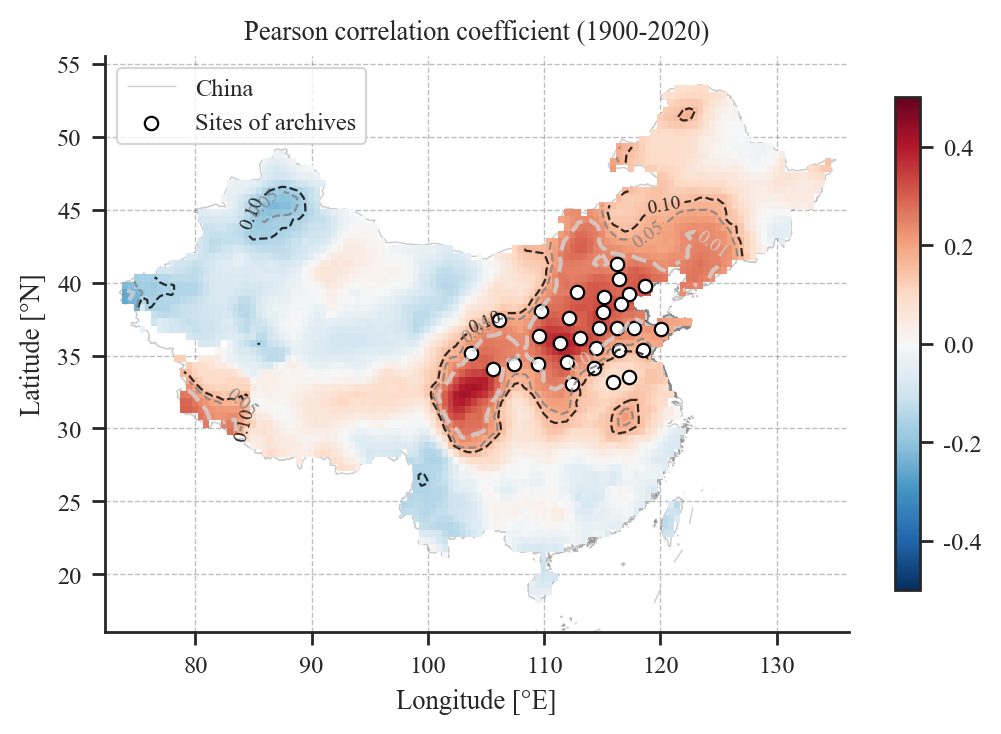

In [11]:
import geopandas as gpd
from shifting_baseline.utils.calc import calc_corr
from shifting_baseline.utils.plot import plot_corr_map
import xarray as xr

outline = gpd.read_file(cfg.how.shp)

series = combined["mean"].to_xarray()
common_years = np.intersect1d(series.year.values, summer_precip_z.year.values)

corr = xr.apply_ufunc(
    calc_corr,
    summer_precip_z.sel(year=common_years),
    series.sel(year=common_years),
    input_core_dims=[["year"], ["year"]],
    output_core_dims=[[], [], []],
    vectorize=True,
    output_dtypes=[float, float, int],
)
ax1 = plot_corr_map(
    corr[0],
    corr[1],
    threshold=0.1,
    mask=False,
    crs=summer_precip_z.rio.crs,
    base_maps=cfg.ds.base_maps,
)
region_gdf.plot(ax=ax1, color="white", edgecolor="black", label="Sites of archives")
ax1.set_title("Pearson correlation coefficient (1900-2020)")
ax1.set_xlabel("Longitude [°E]")
ax1.set_ylabel("Latitude [°N]")
ax1.legend(loc="upper left")
plt.show();

## 分布测定

最佳分布：Student-t（t）表现最佳：

- 最低sumsquare_error（1.003480），表明直方图拟合最好。
- 较低的AIC（495.670695）和BIC（507.652580），优于lognorm和gamma。
- 最低ks_statistic（0.040494）和最高ks_pvalue（0.5134515），CDF拟合极佳。

次佳分布：lognorm：
- sumsquare_error（1.010543）、AIC（500.570491）、BIC（512.552375）略逊于t。
- ks_statistic（0.040599）和ks_pvalue（0.5101007）与t接近，拟合良好。

In [12]:
from shifting_baseline.data import check_distribution
from matplotlib import pyplot as plt


summary = check_distribution(combined["mean"], only_best=False)

summary
log.info(f"可以看出，对树轮数据的最佳分布拟合是：{summary.index[0]}")

INFO | 最佳分布: sumsquare_error      0.834103
aic                413.182779
bic                423.026095
kl_div                    inf
ks_statistic         0.028608
ks_pvalue            0.370802
Name: norm, dtype: float64


2025-09-21 11:27:19.370 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=4.147938)
2025-09-21 11:27:19.372 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.834103)
2025-09-21 11:27:19.380 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=11.35106)
2025-09-21 11:27:19.387 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=2.355058)
2025-09-21 11:27:19.388 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=0.861117)
2025-09-21 11:27:19.404 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=7.655842)
2025-09-21 11:27:19.408 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 distribution with error=0.900563)
2025-09-21 11:27:19.412 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted logn

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,0.834103,413.182779,423.026095,inf,0.028608,0.370802
t,0.835258,414.838517,429.603491,inf,0.028597,0.371253
lognorm,0.838906,415.963948,430.728922,inf,0.030035,0.313409
gamma,0.861117,413.662479,428.427454,inf,0.035572,0.149972
chi2,0.900563,412.640660,427.405634,inf,0.042379,0.050895


INFO | 可以看出，对树轮数据的最佳分布拟合是：norm


合并后的数据符合正态分布

### 历史站点分布在哪里

把每个历史材料站点所在位置的【树轮 v.s. 校验】数据相关性进行记录。

In [23]:
lons = region_gdf.lon.values
lats = region_gdf.lat.values

hist_sites_corr = region_gdf[["name_ch", "name_en", "lon", "lat"]].copy()
rs, ps = [], []
for lon, lat in zip(hist_sites_corr.lon, hist_sites_corr.lat):
    r = corr[0].sel(x=lon, y=lat, method="nearest").item()
    p = corr[1].sel(x=lon, y=lat, method="nearest").item()
    rs.append(r)
    ps.append(p)

hist_sites_corr["r"] = rs
hist_sites_corr["p"] = ps
hist_sites_corr.to_csv(cfg.ds.out.sites_corr, index=False)
# 相关性
hist_sites_corr.head()
hist_sites_corr["r"].describe()

,name_ch,name_en,lon,lat,r,p
15,兰州,Lanzhou,103.726610,35.181546,0.246036,0.008618
16,天水,Tianshui,105.600436,34.110788,0.290081,0.001829
18,银川,Yinchuan,106.135814,37.412291,0.209210,0.026157
21,榆林,Yulin,109.734749,38.066642,0.251915,0.007109
22,延安,Yan'an,109.556290,36.371276,0.305130,0.001015


count    30.000000
mean      0.253075
std       0.073648
min       0.070556
25%       0.211644
50%       0.255205
75%       0.303413
max       0.400251
Name: r, dtype: float64

In [14]:
mask = hist_sites_corr["p"] < 0.1
mask2 = hist_sites_corr["p"] < 0.05
n_sig = mask.sum()
log.info(
    f"{len(hist_sites_corr)} 个站点中，有 {n_sig} 个站点通过了 0.1 显著性水平检验 ({n_sig/len(hist_sites_corr):.2%})"
)

log.info("0.1 显著性水平检验的站点相关性描述性统计：")
hist_sites_corr[mask]["r"].describe()
log.info("0.05 显著性水平检验的站点相关性描述性统计：")
hist_sites_corr[mask2]["r"].describe()

INFO | 30 个站点中，有 27 个站点通过了 0.1 显著性水平检验 (90.00%)
INFO | 0.1 显著性水平检验的站点相关性描述性统计：


count    27.000000
mean      0.269711
std       0.055220
min       0.168985
25%       0.230604
50%       0.279160
75%       0.308849
max       0.400251
Name: r, dtype: float64

INFO | 0.05 显著性水平检验的站点相关性描述性统计：


count    25.000000
mean      0.277167
std       0.050169
min       0.188587
25%       0.246036
50%       0.289927
75%       0.312568
max       0.400251
Name: r, dtype: float64

## 对比自然数据与校验数据

这里我们将展示自然数据的：

- 年值
- 30 年低通滤波
- 上下 1 倍 RMSE 的范围


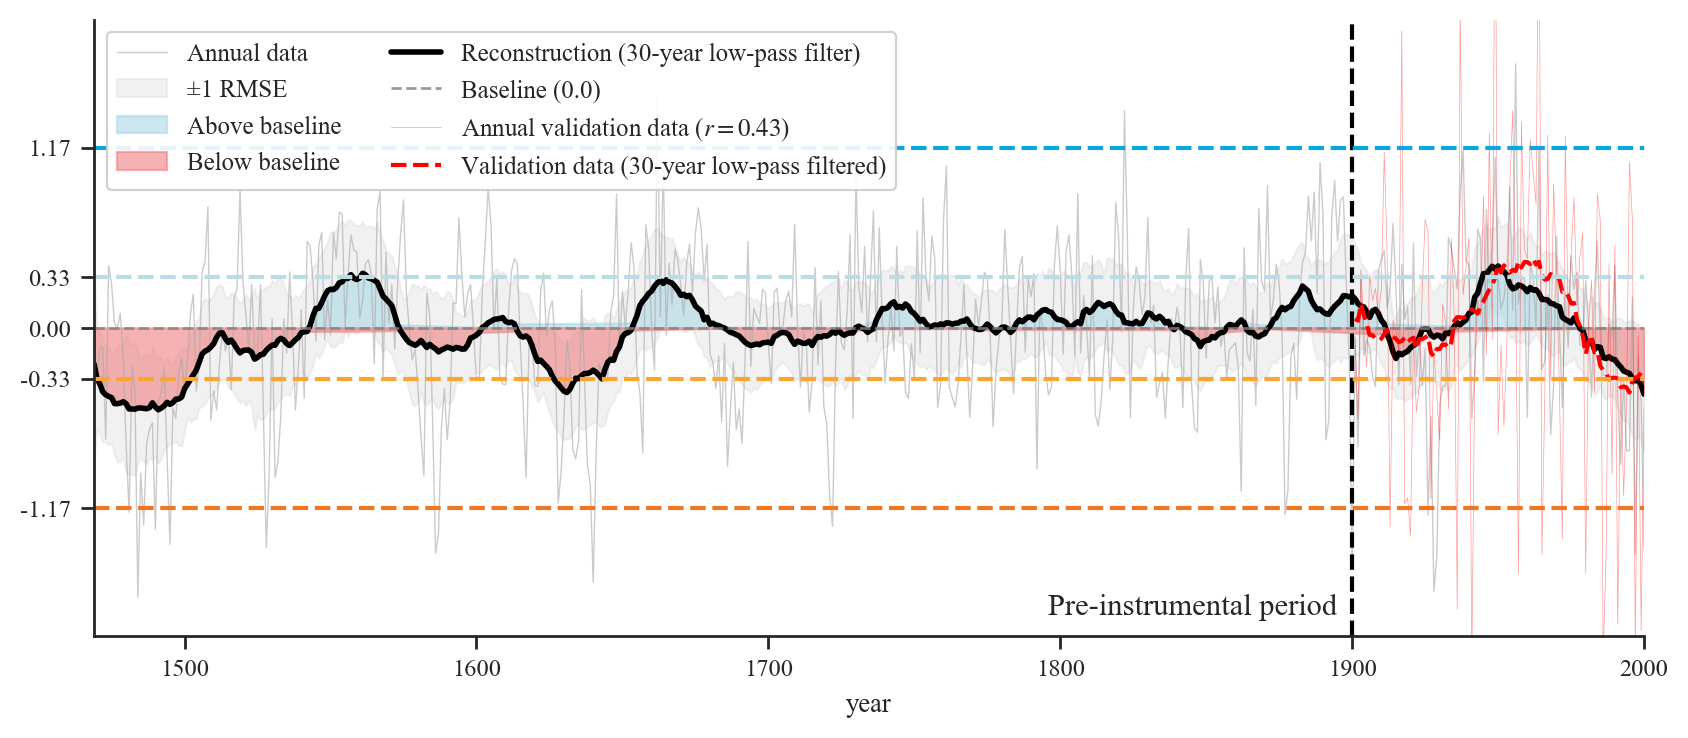

In [18]:
from shifting_baseline.utils.plot import plot_time_series_with_lowpass
from shifting_baseline.utils.calc import low_pass_filter
from shifting_baseline.constants import (
    STAGE1,
    END,
    FINAL,
    THRESHOLDS,
    COLORS,
    STD_THRESHOLDS,
)

tree_ring_z = combined["mean"].loc[STAGE1:FINAL]
tree_ring_std = combined["sd"].loc[STAGE1:FINAL]
# 低通滤波
low_pass_cfg = cfg.get("low_pass", {})
mean_pass = low_pass_filter(tree_ring_z, **low_pass_cfg)
prec_z_pass = low_pass_filter(regional_prec_z, **low_pass_cfg)

validation_corr = regional_prec_z.corr(tree_ring_z.loc[END:FINAL])

# 绘制时间序列
ax1 = plot_time_series_with_lowpass(
    data=tree_ring_z,
    filtered_data=mean_pass,
    baseline=0,
    rmse_data=tree_ring_std,
)
regional_prec_z.plot(
    ax=ax1,
    color="red",
    lw=0.25,
    alpha=0.4,
    label=f"Annual validation data ($r={validation_corr:.2f}$)",
)
prec_z_pass.plot(
    ax=ax1,
    color="red",
    lw=1.5,
    ls="--",
    label="Validation data (30-year low-pass filtered)",
)
ax1.axvline(END, color="black", lw=1.5, ls="--")
ax1.text(END - 5, -1.9, "Pre-instrumental period", ha="right", va="bottom", fontsize=11)

for th, color in zip(THRESHOLDS, COLORS):
    ax1.axhline(th, color=color, lw=1.5, ls="--")
# 设置图例
ax1.legend(loc="upper left", fontsize=9, framealpha=0.9, ncol=2)
ax1.set_xlim(STAGE1, FINAL)
ax1.set_yticks(STD_THRESHOLDS)
ax1.set_ylim(-2, 2)
ax1.set_title("")

plt.show();

绘制合并后的数据可以看出，在第一个阶段波动更明显；1700 之后的波动没有那么明显。

## 对比历史数据与树轮数据

INFO | 共同索引长度: 432
INFO | t 检验: 0.0005320026353811359


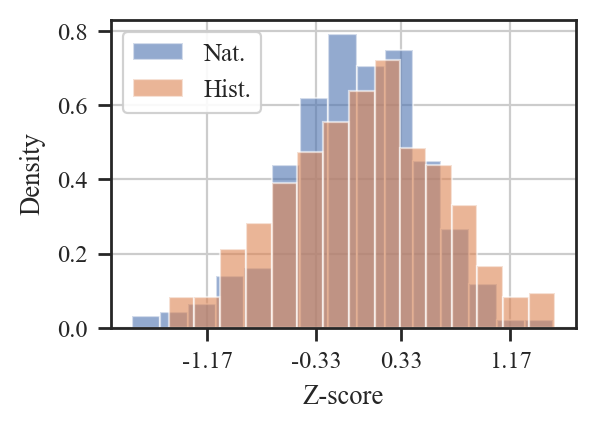

In [19]:
from scipy.stats import ttest_rel

fig, ax1 = plt.subplots(figsize=(3, 2))
tree_ring_subset = tree_ring_z.loc[STAGE1:END]
tree_ring_subset.hist(density=True, alpha=0.6, bins=15, ax=ax1, label="Nat.")

# 历史数据
agg_hist = hist.aggregate(cfg.agg_method, to_int=False)
agg_hist.hist(density=True, alpha=0.6, bins=15, ax=ax1, label="Hist.")

# 确保两个序列有相同的时间范围
common_index = tree_ring_subset.index.intersection(agg_hist.index)
log.info("共同索引长度: %s", len(common_index))

if len(common_index) == 0:
    raise ValueError("没有共同索引，无法进行 t 检验")

# 使用共同索引进行 t 检验
tree_ring_aligned = tree_ring_subset.loc[common_index]
agg_hist_aligned = agg_hist.loc[common_index]

# 检查是否有缺失值
log.debug("tree_ring_aligned 缺失值数量: %s", tree_ring_aligned.isna().sum())
log.debug("agg_hist_aligned 缺失值数量: %s", agg_hist_aligned.isna().sum())

# 移除缺失值
valid_mask = ~(tree_ring_aligned.isna() | agg_hist_aligned.isna())
tree_ring_clean = tree_ring_aligned[valid_mask]
agg_hist_clean = agg_hist_aligned[valid_mask]

log.debug("清理后 tree_ring 形状: %s", tree_ring_clean.shape)
log.debug("清理后 agg_hist 形状: %s", agg_hist_clean.shape)

if len(tree_ring_clean) == 0:
    raise ValueError("没有有效数据，无法进行 t 检验")

ttest = ttest_rel(tree_ring_clean, agg_hist_clean)
log.info("t 检验: %s", ttest.pvalue)

ax1.legend(loc="upper left", fontsize=9, framealpha=0.9, ncol=1)
ax1.set_xticks(THRESHOLDS)
ax1.set_xlabel("Z-score")
ax1.set_ylabel("Density")
ax1.set_title("")
plt.show();

In [20]:
summary = check_distribution(agg_hist, only_best=False)
summary

log.info(f"可以看出，对树轮数据的最佳分布拟合是：{summary.index[0]}")

2025-09-21 11:28:59.780 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=10.713657)
2025-09-21 11:28:59.788 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=2.163453)
2025-09-21 11:28:59.790 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=6.040842)
2025-09-21 11:28:59.790 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=3.582241)
2025-09-21 11:28:59.790 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=6.302897)
2025-09-21 11:28:59.792 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 distribution with error=20.097067)
2025-09-21 11:28:59.797 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=2.176891)
2025-09-21 11:28:59.811 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted 

INFO | 最佳分布: sumsquare_error      2.163453
aic                289.949826
bic                298.058705
kl_div                    inf
ks_statistic         0.021537
ks_pvalue            0.986694
Name: norm, dtype: float64


2025-09-21 11:29:00.513 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=3.267134)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,2.163453,289.949826,298.058705,inf,0.021537,0.986694
t,2.163453,291.949803,304.113121,inf,0.021537,0.986694
lognorm,2.171125,292.138305,304.301623,inf,0.021921,0.983924
gamma,2.176891,291.817970,303.981288,inf,0.022170,0.981933
exponpow,2.286135,276.625837,288.789155,inf,0.037241,0.582709


INFO | 可以看出，对树轮数据的最佳分布拟合是：norm


## 最终作图

图 1 我希望包括以下内容：

- 证明对数论数据的拟合效果不错
- 证明历史数据和数论数据都能在基本的旱涝历史上达到一致
- 证明空间上有代表性
- 证明历史判断比树轮的判断更极端

INFO | 处理为对称等级 ...
INFO | 处理为标准化等级 ...
INFO | 通过随机采样处理为标准化等级，生成 100 个样本 ...


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/data.py:220: RuntimeWarning: Mean of empty slice
  np.nanmean(data, axis=0),
/Users/songshgeo/Documents/VSCode/shifting_baseline/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/s9/w7bh_d6x1h915wcvpbp117tm0000gn/T/ipykernel_56718/709939229.py:103: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax3.legend(loc="upper left", fontsize=9, framealpha=0.9, ncol=1)


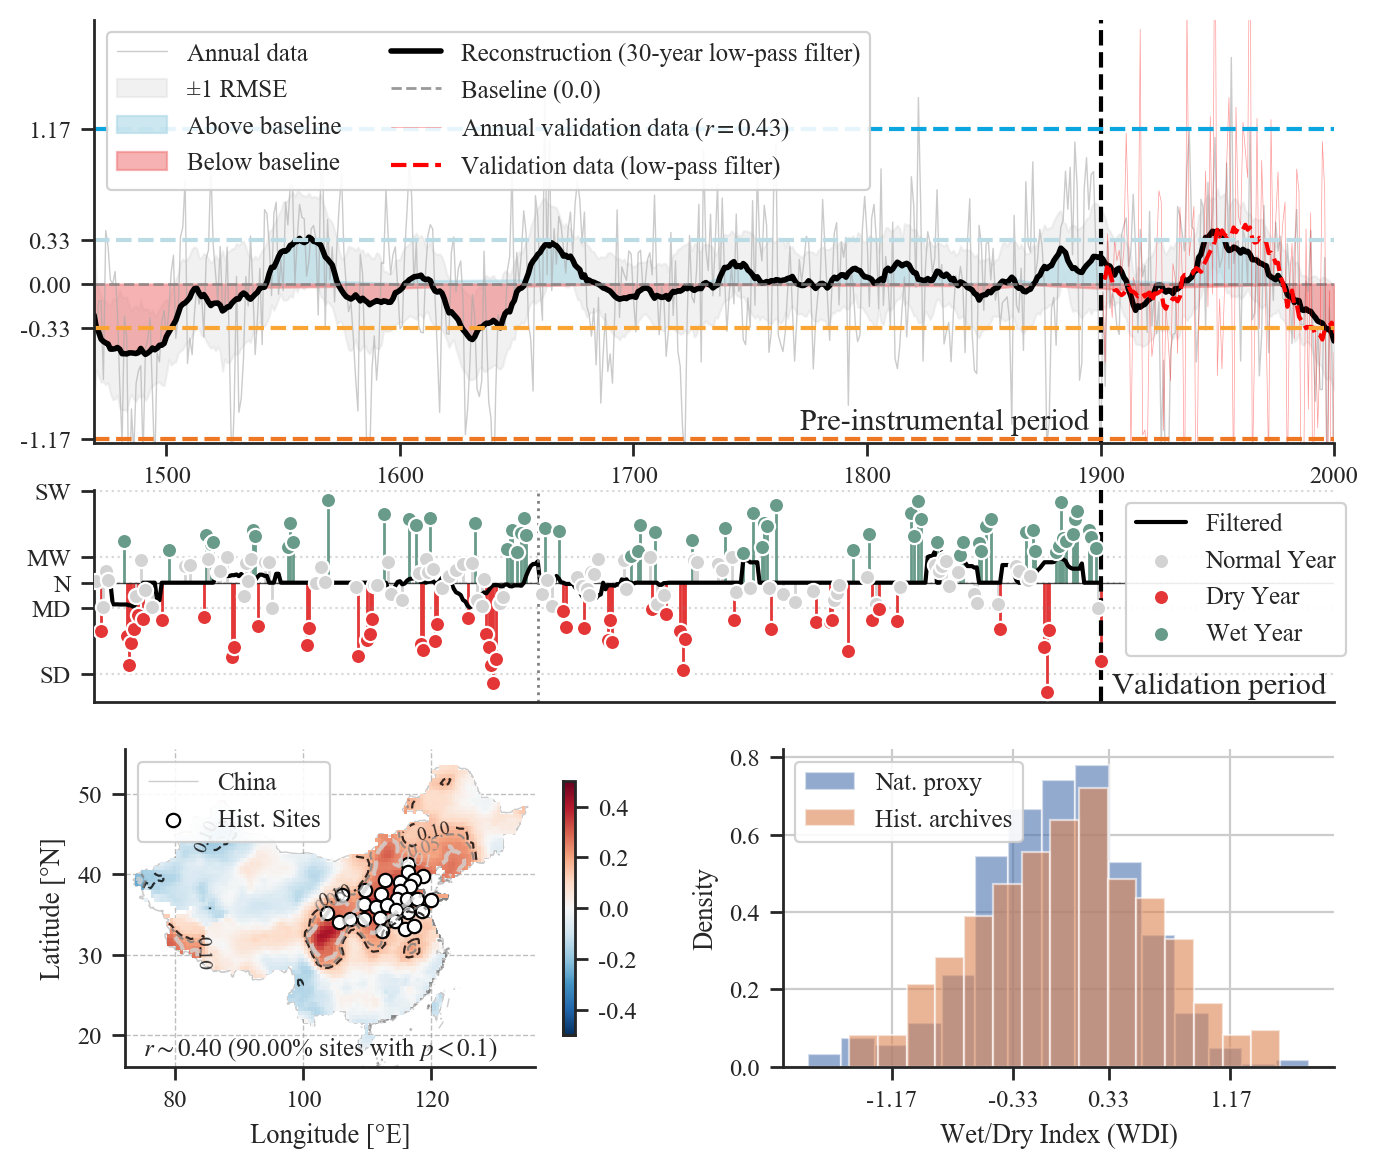

In [25]:
from shifting_baseline.utils.plot import plot_std_times
from shifting_baseline.constants import TICK_LABELS, STAGE2

fig = plt.figure(figsize=(8, 6.8), constrained_layout=False)
gs = fig.add_gridspec(
    3,
    2,
    hspace=0.15,
    wspace=0.25,
    width_ratios=[1, 1],
    height_ratios=[2, 1, 1.5],
)

# ================================================
# 自然数据
ax1 = fig.add_subplot(gs[0, :])

# 绘制时间序列
ax1 = plot_time_series_with_lowpass(
    data=tree_ring_z,
    filtered_data=mean_pass,
    baseline=0,
    rmse_data=tree_ring_std,
    ax=ax1,
)
regional_prec_z.plot(
    ax=ax1,
    color="red",
    lw=0.25,
    alpha=0.4,
    label=f"Annual validation data ($r={validation_corr:.2f}$)",
)
prec_z_pass.plot(
    ax=ax1,
    color="red",
    lw=1.5,
    ls="--",
    label="Validation data (low-pass filter)",
)
ax1.axvline(END, color="black", lw=1.5, ls="--")
ax1.text(
    END - 5, -1.15, "Pre-instrumental period", ha="right", va="bottom", fontsize=11
)

for th, color in zip(THRESHOLDS, COLORS):
    ax1.axhline(th, color=color, lw=1.5, ls="--")
# 设置图例
ax1.legend(loc="upper left", fontsize=9, framealpha=0.9, ncol=2)
ax1.set_xlim(STAGE1, FINAL)
ax1.set_yticks(STD_THRESHOLDS)
ax1.set_ylim(-1.2, 2)
ax1.set_title("")

# ================================================
# 历史数据
# 绘制历史数据，看看哪些年份有记录
ax2 = fig.add_subplot(gs[1, :])

history = HistoricalRecords(
    shp_path=cfg.ds.atlas.shp,
    data_path=cfg.ds.atlas.file,
    symmetrical_level=True,
    to_std=cfg.to_std,
)

data = history.aggregate(to_int=False).loc[STAGE1:END]
low_pass_filter(data=data).fillna(0).plot(
    ax=ax2, color="black", lw=1.5, label="Filtered"
)
ax2 = plot_std_times(data, ax=ax2, zorder=-1)
ax2.set_yticks(STD_THRESHOLDS)
ax2.set_xlim(STAGE1, FINAL)
ax2.set_yticklabels(TICK_LABELS)
ax2.axvline(END, color="black", lw=1.5, ls="--")
ax2.axvline(STAGE2, color="gray", lw=1, ls=":")
ax2.set_ylabel("")
ax2.legend(
    loc="upper right", fontsize=9, framealpha=0.9, ncol=1, bbox_to_anchor=(1.02, 1)
)
ax2.text(END + 5, -1.5, "Validation period", ha="left", va="bottom", fontsize=11)

# ================================================
# 空间分布
ax3 = fig.add_subplot(gs[2, 0])
ax3 = plot_corr_map(
    corr[0],
    corr[1],
    threshold=0.1,
    mask=False,
    base_maps=cfg.ds.base_maps,
    crs=summer_precip_z.rio.crs,
    ax=ax3,
)
region_gdf.plot(ax=ax3, color="white", edgecolor="black", label="Hist. Sites")
ax3.set_xlabel("Longitude [°E]")
ax3.set_ylabel("Latitude [°N]")
ax3.text(
    75,
    20,
    f'$r\sim{hist_sites_corr[mask]["r"].max():.2f}$ ({mask.sum()/len(hist_sites_corr):.2%} sites with $p<0.1$)',
    ha="left",
    va="top",
    fontsize=9,
)
ax3.legend(loc="upper left", fontsize=9, framealpha=0.9, ncol=1)

## ================================================
BINS = 15
ax4 = fig.add_subplot(gs[2, 1])
tree_ring_z.hist(density=True, alpha=0.6, bins=BINS, ax=ax4, label="Nat. proxy")
agg_hist.hist(density=True, alpha=0.6, bins=BINS, ax=ax4, label="Hist. archives")
ax4.set_ylabel("Density")
ax4.set_xlabel("Wet/Dry Index (WDI)")
ax4.set_xticks(THRESHOLDS)
ax4.legend(loc="upper left", fontsize=9, framealpha=0.9, ncol=1)

# ================================================
# 设置整体作图的样式
for ax in fig.axes:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
ax2.get_xaxis().set_visible(False)
plt.show();

### 测试每个数据被删除一遍

In [26]:
from itertools import combinations


def get_all_combinations(lst):
    """获取列表所有长度>=2的组合"""
    all_combinations = []
    for r in range(2, len(lst) + 1):  # 从长度2开始到列表长度
        all_combinations.extend(list(combinations(lst, r)))
    return all_combinations


# 示例
data_list = [
    "chen2020f",
    "li2015b",
    "li2019a",
    "liu2020",
    "shi2017",
    "shi2018",
    "tan2011",
    "xu2023c",
    "yang2016",
    "yi2010",
    "yi2012",
]
comb_list = get_all_combinations(data_list)
print(f"总共有 {len(comb_list)} 种组合")
print("前5个组合示例:")
for i, combo in enumerate(comb_list[:5]):
    print(f"{i+1}: {combo}")

总共有 2036 种组合
前5个组合示例:
1: ('chen2020f', 'li2015b')
2: ('chen2020f', 'li2019a')
3: ('chen2020f', 'liu2020')
4: ('chen2020f', 'shi2017')
5: ('chen2020f', 'shi2018')


In [ ]:
# 测试每个数据都被导出一遍
test_corr = pd.Series()

for col in datasets:
    tmp_datsets = datasets.copy()
    tmp_uncertainties = uncertainties.copy()
    tmp_datsets.drop(columns=[col], inplace=True)
    tmp_uncertainties.drop(columns=[col], inplace=True)
    tmp_combined, tmp_trace = combine_reconstructions(
        tmp_datsets,
        tmp_uncertainties,
        standardize=True,
    )
    test_corr[col] = regional_prec_z.corr(tmp_combined["mean"].loc[END:FINAL])

ratio = (test_corr - validation_corr) / validation_corr
sensitive = pd.concat([test_corr, ratio], axis=1);

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_drought, nu]


Output()

In [ ]:
sensitive